In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm

In [18]:
class GridWorlddp(object):
    def __init__(self, p=0.55):
        # Shape of the gridworld
        self.shape = (6,6)
        
        # Locations of the obstacles
        self.obstacle_locs = [(1,1),(2,5),(2,3),(3,1),(4,1),(4,2),(4,4)]
        
        # Locations for the terminal/absorbing states
        self.absorbing_locs = [(4,3),(1,3)]
        
        # Rewards for each of the absorbing states 
        self.special_rewards = [-100, 10] # Corresponds to each of the absorbing_locs
        
        # Reward for all the other states
        self.default_reward = -1
        
        # Action names
        self.action_names = ['N','E','S','W'] # Action 0 is 'N', 1 is 'E' and so on
        
        # Number of actions
        self.action_size = len(self.action_names)
        
        #action probabilty p
        self.p = p
        
        # Get attributes defining the world
        state_size, T, R, absorbing, locs = self.build_grid_world()
        
        # randomly select a starting location
        locs_available = locs.copy()
        locs_available.remove(self.absorbing_locs[0])
        locs_available.remove(self.absorbing_locs[1])
        self.starting_loc = locs_available[np.random.choice(range(len(locs_available)))]
        
        # Number of valid states in the gridworld (there are 22 of them - 5x5 grid minus obstacles)
        self.state_size = state_size
        
        # Transition operator (3D tensor)
        self.T = T # T[st+1, st, a] gives the probability that action a will 
                   # transition state st to state st+1
        
        # Reward function (3D tensor)
        self.R = R # R[st+1, st, a ] gives the reward for transitioning to state
                   # st+1 from state st with action a
        
        # Absorbing states
        self.absorbing = absorbing
        
        # The locations of the valid states 
        self.locs = locs # State 0 is at the location self.locs[0] and so on
        
        # Number of the starting state
        self.starting_state = self.loc_to_state(self.starting_loc, locs);
        
        # Locating the initial state
        self.initial = np.zeros((1,len(locs)));
        self.initial[0,self.starting_state] = 1
        
        # Placing the walls on a bitmap
        self.walls = np.zeros(self.shape);
        for ob in self.obstacle_locs:
            self.walls[ob] = -150
            
        # Placing the absorbers on a grid for illustration
        self.absorbers = np.zeros(self.shape)
        for ab in self.absorbing_locs:
            self.absorbers[ab] = -1
        
        # Placing the rewarders on a grid for illustration
        self.rewarders = np.zeros(self.shape)
        for i, rew in enumerate(self.absorbing_locs):
            self.rewarders[rew] = self.special_rewards[i]
        
    
    def build_grid_world(self):
        # Get the locations of all the valid states, the neighbours of each state (by state number),
        # and the absorbing states (array of 0's with ones in the absorbing states)
        locations, neighbours, absorbing = self.get_topology()
        
        # Get the number of states
        S = len(locations)
        
        # Initialise the transition matrix
        T = np.zeros((S,S,4))
        
#         for action in range(4):
#             for effect in range(4):
#                 # Randomize the outcome of taking an action
#                 outcome = (action+effect+1) % 4
#                 if outcome == 0:
#                     outcome = 3
#                 else:
#                     outcome -= 1
#                 prob = [0.8,0.1,0,0.1][effect]
#                 for prior_state in range(S):
#                     post_state = neighbours[prior_state, outcome]
#                     post_state = int(post_state)
#                     T[post_state,prior_state,action] = T[post_state,prior_state,action]+prob
        
        #define the transition dynamics 
        for prior_state in range(S):
            for action in range(4):
                for effect in range(4):
                    if action == effect:
                        post_state = int(neighbours[prior_state, action])
                        T[post_state,prior_state,action] += self.p
                    else:
                        post_state = int(neighbours[prior_state, effect])
                        T[post_state,prior_state,action] += (1-self.p)/3
    
        # Build the reward matrix
        R = self.default_reward*np.ones((S,S,4))
        for i, sr in enumerate(self.special_rewards):
            post_state = self.loc_to_state(self.absorbing_locs[i],locations)
            R[post_state,:,:]= sr
        
        return S, T,R,absorbing,locations
    

    def get_topology(self):
        height = self.shape[0]
        width = self.shape[1]
        
        index = 1 
        locs = []
        neighbour_locs = []
        
        for i in range(height):
            for j in range(width):
                # Get the locaiton of each state
                loc = (i,j)
                
                #And append it to the valid state locations if it is a valid state (ie not absorbing)
                if(self.is_location(loc)):
                    locs.append(loc)
                    
                    # Get an array with the neighbours of each state, in terms of locations
                    local_neighbours = [self.get_neighbour(loc,direction) for direction in ['nr','ea','so', 'we']]
                    neighbour_locs.append(local_neighbours)
                
        # translate neighbour lists from locations to states
        num_states = len(locs)
        state_neighbours = np.zeros((num_states,4))
        
        for state in range(num_states):
            for direction in range(4):
                # Find neighbour location
                nloc = neighbour_locs[state][direction]
                
                # Turn location into a state number
                nstate = self.loc_to_state(nloc,locs)
      
                # Insert into neighbour matrix
                state_neighbours[state,direction] = nstate;
                
    
        # Translate absorbing locations into absorbing state indices
        absorbing = np.zeros((1,num_states))
        for a in self.absorbing_locs:
            absorbing_state = self.loc_to_state(a,locs)
            absorbing[0,absorbing_state] =1
        
        return locs, state_neighbours, absorbing 


    def loc_to_state(self,loc,locs):
        #takes list of locations and gives index corresponding to input loc
        return locs.index(tuple(loc))


    def is_location(self, loc):
        # It is a valid location if it is in grid and not obstacle
        if(loc[0]<0 or loc[1]<0 or loc[0]>self.shape[0]-1 or loc[1]>self.shape[1]-1):
            return False
        elif(loc in self.obstacle_locs):
            return False
        else:
             return True
            
    def get_neighbour(self,loc,direction):
        #Find the valid neighbours (ie that are in the grif and not obstacle)
        i = loc[0]
        j = loc[1]
        
        nr = (i-1,j)
        ea = (i,j+1)
        so = (i+1,j)
        we = (i,j-1)
        
        # If the neighbour is a valid location, accept it, otherwise, stay put
        if(direction == 'nr' and self.is_location(nr)):
            return nr
        elif(direction == 'ea' and self.is_location(ea)):
            return ea
        elif(direction == 'so' and self.is_location(so)):
            return so
        elif(direction == 'we' and self.is_location(we)):
            return we
        else:
            #default is to return to the same location
            return loc
    
    def get_transition_matrix(self):
        return self.T
    
    def get_reward_matrix(self):
        return self.R
    
    #policy evaluation and iteration
    def policy_iteration(self, discount=0.55, threshold = 0.0001):
        ## Slide 139 of the lecture notes for pseudocode ##
        
        # Transition and reward matrices, both are 3d tensors, c.f. internal state
        T = self.get_transition_matrix()
        R = self.get_reward_matrix()
        
        # Initialisation
        policy = np.zeros((self.state_size, self.action_size)) # Vector of 0
        policy[:,0] = 1 # Initialise policy to choose action 1 systematically
        epochs = 0
        policy_stable = False # Condition to stop the main loop

        while not(policy_stable): 

            # Policy evaluation
            V, epochs_eval = self.policy_evaluation(policy, threshold, discount)
            epochs += epochs_eval # Increment epoch

            # Set the boolean to True, it will be set to False later if the policy prove unstable
            policy_stable = True

            # Policy iteration
            for state_idx in range(policy.shape[0]):
                
                # If not an absorbing state
                if not(self.absorbing[0,state_idx]):
                    
                    # Store the old action
                    old_action = np.argmax(policy[state_idx,:])
                
                    # Compute Q value
                    Q = np.zeros(4) # Initialise with value 0
                    for state_idx_prime in range(policy.shape[0]):
                        Q += T[state_idx_prime,state_idx,:] * (R[state_idx_prime,state_idx, :] + discount * V[state_idx_prime])

                    # Compute corresponding policy
                    new_policy = np.zeros(4)
                    new_policy[np.argmax(Q)] = 1  # The action that maximises the Q value gets probability 1
                    policy[state_idx] = new_policy
                
                    # Check if the policy has converged
                    if old_action != np.argmax(policy[state_idx]):
                        policy_stable = False
            
        return V, policy, epochs
                
        
    
    def policy_evaluation(self, policy, threshold, discount):
        
        # Make sure delta is bigger than the threshold to start with
        delta= 2*threshold
        
        #Get the reward and transition matrices
        R = self.get_reward_matrix()
        T = self.get_transition_matrix()
        
        # The value is initialised at 0
        V = np.zeros(policy.shape[0])
        # Make a deep copy of the value array to hold the update during the evaluation
        Vnew = np.copy(V)
        
        epoch = 0
        # While the Value has not yet converged do:
        while delta>threshold:
            epoch += 1
            for state_idx in range(policy.shape[0]):
                # If it is one of the absorbing states, ignore
                if(self.absorbing[0,state_idx]):
                    continue   
                
                # Accumulator variable for the Value of a state
                tmpV = 0
                for action_idx in range(policy.shape[1]):
                    # Accumulator variable for the State-Action Value
                    tmpQ = 0
                    for state_idx_prime in range(policy.shape[0]):
                        tmpQ = tmpQ + T[state_idx_prime,state_idx,action_idx] * (R[state_idx_prime,state_idx, action_idx] + discount * V[state_idx_prime])
                    
                    tmpV += policy[state_idx,action_idx] * tmpQ
                    
                # Update the value of the state
                Vnew[state_idx] = tmpV
            
            # After updating the values of all states, update the delta
            # Note: The below is our example way of computing delta.
            #       Other stopping criteria may be used (for instance mean squared error).
            #       We encourage you to explore different ways of computing delta to see 
            #       how it can influence outcomes.
            delta =  max(abs(Vnew-V))
            # and save the new value into the old
            V=np.copy(Vnew)
            
        return V, epoch
    
    #drawing functions
    def draw_deterministic_policy(self, Policy):
        # Draw a deterministic policy
        # The policy needs to be a np array of 22 values between 0 and 3 with
        # 0 -> N, 1->E, 2->S, 3->W
        plt.figure()
        
        plt.imshow(self.walls+self.rewarders +self.absorbers) # Create the graph of the grid
        #plt.hold('on')
        for state, action in enumerate(Policy):
            if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any action
                continue
            arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
            action_arrow = arrows[action] # Take the corresponding action
            location = self.locs[state] # Compute its location on graph
            plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
    
        plt.show()
    
    def draw_value(self, Value):
        # Draw a policy value function
        # The value need to be a np array of 22 values 
        plt.figure()
        
        plt.imshow(self.walls+self.rewarders +self.absorbers) # Create the graph of the grid
        for state, value in enumerate(Value):
            if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any value
                continue
            location = self.locs[state] # Compute the value location on graph
            plt.text(location[1], location[0], round(value,2), ha='center', va='center') # Place it on graph
    
        plt.show()
    
    def draw_deterministic_policy_grid(self, Policy, title, n_columns, n_lines):
        # Draw a grid of deterministic policy
        # The policy needs to be an arrya of np array of 22 values between 0 and 3 with
        # 0 -> N, 1->E, 2->S, 3->W
        plt.figure(figsize=(20,8))
        for subplot in range (len(Policy)): # Go through all policies
          ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each policy
          ax.imshow(self.walls+self.rewarders +self.absorbers) # Create the graph of the grid
          for state, action in enumerate(Policy[subplot]):
              if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any action
                  continue
              arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
              action_arrow = arrows[action] # Take the corresponding action
              location = self.locs[state] # Compute its location on graph
              plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
          ax.title.set_text(title[subplot]) # Set the title for the graoh given as argument
        plt.show()

    def draw_value_grid(self, Value, title, n_columns, n_lines):
        # Draw a grid of value function
        # The value need to be an array of np array of 22 values 
        plt.figure(figsize=(20,8))
        for subplot in range (len(Value)): # Go through all values
          ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each value
          ax.imshow(self.walls+self.rewarders +self.absorbers) # Create the graph of the grid
          for state, value in enumerate(Value[subplot]):
              if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any value
                  continue
              location = self.locs[state] # Compute the value location on graph
              plt.text(location[1], location[0], round(value,1), ha='center', va='center') # Place it on graph
          ax.title.set_text(title[subplot]) # Set the title for the graoh given as argument
        plt.show()
    



Its graphical representation is:



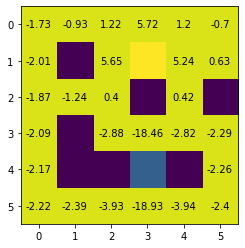



Its graphical representation is:



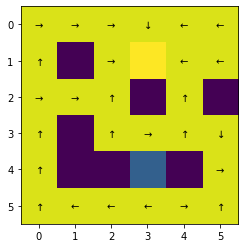

In [56]:
#get the optimal value function and optimal policy
grid = GridWorlddp()
V_opt, pol_opt, epochs = grid.policy_iteration()
print("\n\nIts graphical representation is:\n")
grid.draw_value(V_opt)
print("\n\nIts graphical representation is:\n")
grid.draw_deterministic_policy(np.array([np.argmax(pol_opt[row,:]) for row in range(grid.state_size)]))


Graphical representation of the value function for each gamma:



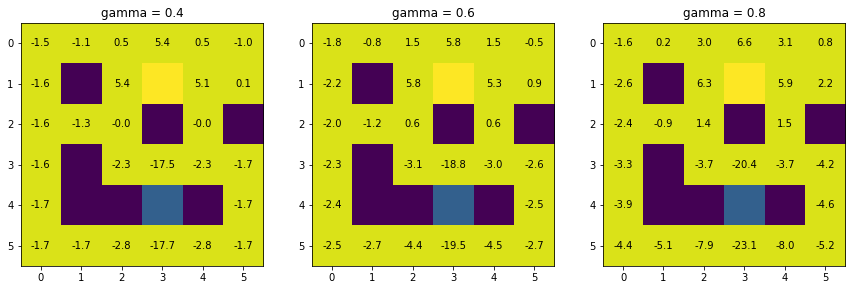


Graphical representation of the policy for each gamma:



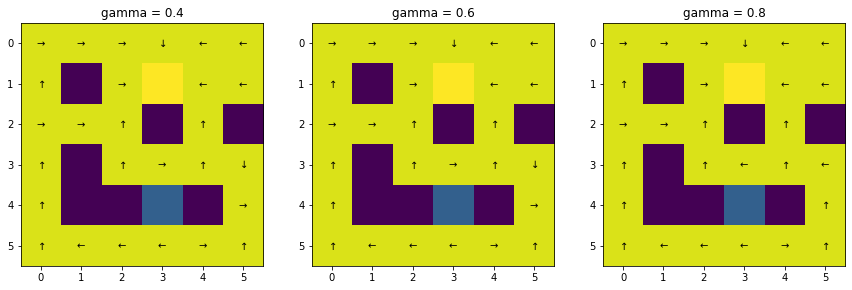

In [61]:
#test different gamma values
gamma_range = [0.4, 0.6, 0.8]
# Use policy iteration for each gamma value
#initialize
epochs_needed = []
pols_needed = []
vals_needed = []
titles = []
for gamma in gamma_range:
    grid = GridWorlddp()
    V_opt, pol_opt, epochs = grid.policy_iteration(discount = gamma)
    epochs_needed.append(epochs)
    pols_needed.append(np.array([np.argmax(pol_opt[row,:]) for row in range(grid.state_size)]))
    vals_needed.append(V_opt)
    titles.append(f"gamma = {gamma}")

print("\nGraphical representation of the value function for each gamma:\n")
grid.draw_value_grid(vals_needed, titles, 1, 4)

print("\nGraphical representation of the policy for each gamma:\n")
grid.draw_deterministic_policy_grid(pols_needed, titles, 1, 4)


Graphical representation of the value function for each p:



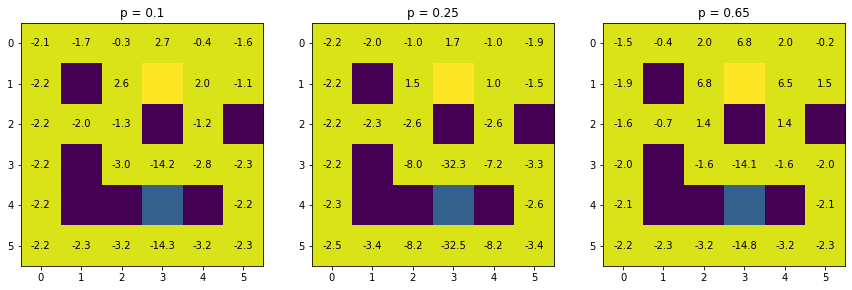


Graphical representation of the policy for each p:



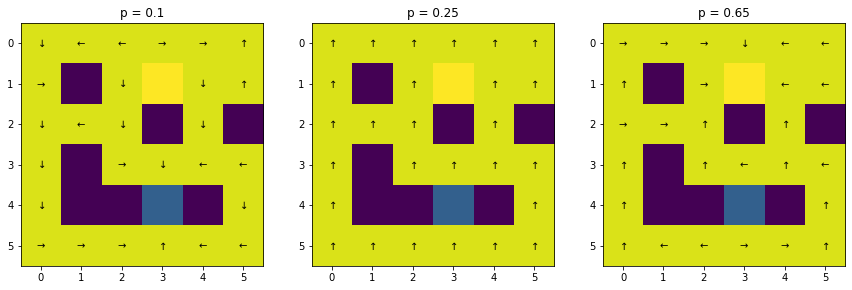

In [63]:
#test different p values
p_range = [0.1, 0.25, 0.65]
#policy iteration for each p value
#initialize
epochs_needed = []
pols_needed = []
vals_needed = []
titles = []
for p_val in p_range:
    grid = GridWorlddp(p=p_val)
    V_opt, pol_opt, epochs = grid.policy_iteration()
    epochs_needed.append(epochs)
    pols_needed.append(np.array([np.argmax(pol_opt[row,:]) for row in range(grid.state_size)]))
    vals_needed.append(V_opt)
    titles.append(f"p = {p_val}")

print("\nGraphical representation of the value function for each p:\n")
grid.draw_value_grid(vals_needed, titles, 1, 4)

print("\nGraphical representation of the policy for each p:\n")
grid.draw_deterministic_policy_grid(pols_needed, titles, 1, 4)

In [31]:
#DP optimal
grid5 = GridWorlddp()
V_opt_dp, P_opt_dp, _ = grid5.policy_iteration()
V_OPT = V_opt_dp  #the true optimal state values (ground truth) set as global variable

In [32]:
class GridWorldenv(object):
    def __init__(self, p=0.55, curr_state=28):
        #shape of the grid
        self.shape = (6,6)
        #Locations of the obstacles
        self.obstacle_locs = [(1,1),(2,5),(2,3),(3,1),(4,1),(4,2),(4,4)]
        #all possible actions
        self.action_names = ['N','E','S','W'] # Action 0 is 'N', 1 is 'E' and so on
        #Number of actions
        self.action_size = len(self.action_names)
        #action probabilty p
        self.p = p
        #all locations
        self.locs = self.get_all_locs()
        #number of states
        self.num_state = len(self.locs)
        #Locations for the terminal/absorbing states
        self.absorbing_locs = [(4,3),(1,3)]
        self.absorbing_states = []
        for loc in self.absorbing_locs:
            self.absorbing_states.append(self.loc_to_state(loc, self.locs))
        #current location/state
        self.curr_state = curr_state
        self.curr_loc = self.locs[self.curr_state]
        
        #for visualisation of the gridworld:
        # Placing the walls on a bitmap
        self.walls = np.zeros(self.shape);
        for ob in self.obstacle_locs:
            self.walls[ob] = -150
            
        # Placing the absorbers on a grid for illustration
        self.absorbers = np.zeros(self.shape)
        for ab in self.absorbing_locs:
            self.absorbers[ab] = -1
        
        # Placing the terminal states on a grid for illustration
        self.rewarders = np.zeros(self.shape)
        for i, rew in enumerate(self.absorbing_locs):
            self.rewarders[rew] = [-100,10][i]
    
    
    def get_all_locs(self):
        #get all valid locs
        locs = []
        for i in range(self.shape[0]):
            for j in range(self.shape[1]):
                if self.is_location((i, j)):
                    locs.append((i, j))
        return locs
    
    def loc_to_state(self,loc,locs):
        #takes list of locations and gives index corresponding to input loc
        return locs.index(tuple(loc))


    def is_location(self, loc):
        # It is a valid location if it is in grid and not obstacle
        if(loc[0]<0 or loc[1]<0 or loc[0]>self.shape[0]-1 or loc[1]>self.shape[1]-1):
            return False
        elif(loc in self.obstacle_locs):
            return False
        else:
             return True
    
    def env_start(self):
        #start the environment and randomly pick a starting loc(1/27)
        locs_available = self.locs.copy()
        locs_available.remove(self.absorbing_locs[0])
        locs_available.remove(self.absorbing_locs[1])
        self.curr_loc = locs_available[np.random.choice(range(len(locs_available)))]
        self.curr_state = self.loc_to_state(self.curr_loc, self.locs)
        
    
    def env_step(self, action):
        #env decides the action [n,e,s,w], with non-deterministic transition
        self.curr_loc = self.locs[self.curr_state]
        possible_next_locs = [(self.curr_loc[0]-1,self.curr_loc[1]),
                              (self.curr_loc[0],self.curr_loc[1]+1),
                              (self.curr_loc[0]+1,self.curr_loc[1]),
                              (self.curr_loc[0],self.curr_loc[1]-1)]
        if action == 0:
            if np.random.uniform(0,1)<=self.p:
                next_loc = possible_next_locs[0]
                actual_action = action
            else:
                next_loc = possible_next_locs[np.random.choice([1,2,3])]
                actual_action = possible_next_locs.index(next_loc)
        elif action == 1:
            if np.random.uniform(0,1)<=self.p:
                next_loc = possible_next_locs[1]
                actual_action = action
            else:
                next_loc = possible_next_locs[np.random.choice([0,2,3])]
                actual_action = possible_next_locs.index(next_loc)
        elif action == 2:
            if np.random.uniform(0,1)<=self.p:
                next_loc = possible_next_locs[2]
                actual_action = action
            else:
                next_loc = possible_next_locs[np.random.choice([0,1,3])]
                actual_action = possible_next_locs.index(next_loc)
        elif action == 3:
            if np.random.uniform(0,1)<=self.p:
                next_loc = possible_next_locs[3]
                actual_action = action
            else:
                next_loc = possible_next_locs[np.random.choice([0,1,2])]
                actual_action = possible_next_locs.index(next_loc)
        else:
            raise Exception(self.action_names[action]+'is not in available actions!')
        
        #check validity of the move
        if self.is_location(next_loc):
            next_position = next_loc
        else:
            next_position = self.curr_loc
        
        #reward function
        if next_position == self.absorbing_locs[0]:
            reward = -100
            done = True
        elif next_position == self.absorbing_locs[1]:
            reward = 10
            done = True
        else:
            reward = -1
            done = False
        
        next_state = self.loc_to_state(next_position, self.locs)
        
        return next_state, reward, done
    
    #drawing functions
    def draw_deterministic_policy(self, Policy):
        # Draw a deterministic policy
        # The policy needs to be a np array of 22 values between 0 and 3 with
        # 0 -> N, 1->E, 2->S, 3->W
        plt.figure()
        
        plt.imshow(self.walls+self.rewarders +self.absorbers) # Create the graph of the grid
        #plt.hold('on')
        for state, action in enumerate(Policy):
            if state in self.absorbing_states: # If it is an absorbing state, don't plot any action
                continue
            arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
            action_arrow = arrows[action] # Take the corresponding action
            location = self.locs[state] # Compute its location on graph
            plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
    
        plt.show()
    
    def draw_value(self, Value):
        # Draw a policy value function
        # The value need to be a np array of 22 values 
        plt.figure()
        
        plt.imshow(self.walls+self.rewarders +self.absorbers) # Create the graph of the grid
        for state, value in enumerate(Value):
            if state in self.absorbing_states: # If it is an absorbing state, don't plot any value
                continue
            location = self.locs[state] # Compute the value location on graph
            plt.text(location[1], location[0], round(value,2), ha='center', va='center') # Place it on graph
    
        plt.show()

In [45]:
class MC_agent(object):
    def __init__(self, epsilon=0.1, step_size=0.2):
        self.agent_env = GridWorldenv()
        self.actions = list(range(self.agent_env.action_size)) #[0,1,2,3]
        self.step_size = step_size
        self.epsilon = epsilon
        self.discount = 0.55
        self.samples = []
        self.qvalues = np.zeros((self.agent_env.num_state,len(self.actions)))
    
    def argmax(self, q_values):
        #argmax with random tie-breaking
        top=float("-inf")
        ties=[]

        for i in self.actions:
            if q_values[i]>top:
                top=q_values[i]
                ties=[]

            if q_values[i]==top:
                ties.append(i)

        return np.random.choice(ties)
    
    def choose_action(self, state):
        #agent choose an action given the current state, according to epsilon-greedy
        if np.random.uniform(0,1)<self.epsilon:
            #take random action
            action = np.random.choice(self.actions)
        else:
            #take action according to the q function
            action = self.argmax(self.qvalues[state])
        return int(action)
    
    def update(self):
        #update the q function at the end of episode
        G = 0
        for tup in self.samples[::-1]:
            state, action = (tup[0],tup[1])
            G = self.discount*G + tup[2]
            self.qvalues[state][action] = (self.qvalues[state][action] + self.step_size*(G - self.qvalues[state][action]))
    
    def reset(self):
        self.agent_env = GridWorldenv()
    
    def play(self, num_episode=2000):
        self.total_reward = np.zeros(num_episode)
        self.total_rms = np.zeros(num_episode)
        #start to generate a trace
        for i in range(num_episode):
            self.agent_env.env_start()
            state = self.agent_env.curr_state
            action = self.choose_action(state)
            
            #cumulative_reward = 0
            while True:
                next_state, reward, done = self.agent_env.env_step(action)
                self.samples.append((self.agent_env.curr_state,action,reward))
                self.agent_env.curr_state = next_state 
                #cumulative_reward += reward
                
                action = self.choose_action(next_state)
                
                #now update the q function at the end of each episode
                if done:
                    #print(f"episode : {i}")
                    self.update()
                    self.total_rms[i] = self.get_rms()
                    self.total_reward[i] = self.back_discounted_reward(sample=self.samples)
                    if i < (num_episode-1):
                        self.samples = []
                    self.reset()
                    break
    
    def back_discounted_reward(self, sample):
        #find the backward discounted reward for one episode
        G_return = 0
        for tup in sample:
            reward = tup[2]
            G_return = self.discount*G_return + reward
        return G_return
    
    def get_rms(self):
        V_estimate = np.max(self.qvalues,axis=1)
        rms = np.sqrt(np.mean((V_estimate-V_OPT)**2))
        return rms
    
    def train_q_values(self, q_values):
        #takes in q_values for training
        self.qvalues = q_values


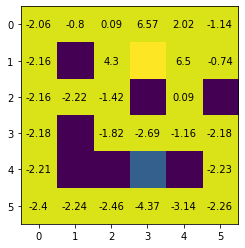

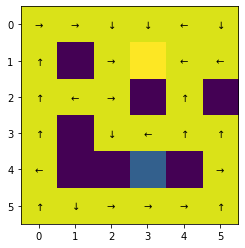

In [54]:
#train the MC agent
agent0 = MC_agent()
agent0.play(num_episode=500000)
TRAINED_Q = agent0.qvalues
grid3 = GridWorldenv()
V_opt_mc = np.max(agent0.qvalues,axis=1) #the optimal value function
P_opt_mc = np.argmax(agent0.qvalues,axis=1)
grid3.draw_value(V_opt_mc)
grid3.draw_deterministic_policy(P_opt_mc)

In [4]:
#the smoothing function for helping visualising trends in plots
def smooth_rewards(total_rewards, smoothing_interval):
    data = []
    for i in range(0,len(total_rewards),smoothing_interval):
        data.append(np.mean(total_rewards[i:i+smoothing_interval]))
    smooth_index = list(range(0,len(total_rewards),smoothing_interval))
    return smooth_index, data

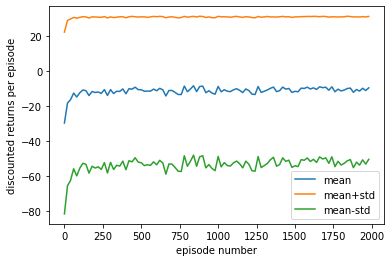

In [5]:
#plot learning curve for Q2c3
iterations = 1000
episode_num = 2000
repeat_reward = np.zeros((iterations,episode_num))
for i in (range(iterations)):
    agent = MC_agent()
    agent.play(episode_num)
    repeat_reward[i] = agent.total_reward
mean_reward = np.mean(repeat_reward, axis=0)
std_reward = np.std(repeat_reward, axis=0)
plus = mean_reward + std_reward
minus = mean_reward - std_reward
#no smoothing
idx, val = smooth_rewards(mean_reward,1)
_, val1 = smooth_rewards(plus,1)
_, val2 = smooth_rewards(minus,1)
fig0 = plt.figure()
plt.plot(idx, val, label="mean")
plt.plot(idx, val1, label="mean+std")
plt.plot(idx, val2, label="mean-std")
plt.xlabel('episode number')
plt.ylabel('discounted returns per episode')
plt.title('MC')
plt.legend()
plt.show()

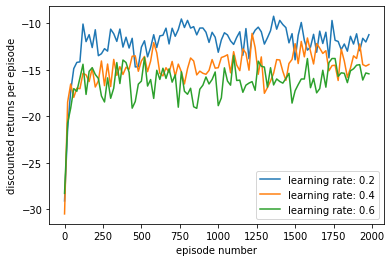

In [9]:
#parameter adjusting for learning rate a for Q2c4
iterations = 100
episode_num = 2000
stepsizes = [0.2, 0.4, 0.6]
repeat_reward = np.zeros((len(stepsizes),iterations,episode_num))
for i in (range(iterations)):
    for idx,a in enumerate(stepsizes):
        agent = MC_agent(step_size=a)
        agent.play(episode_num)
        repeat_reward[idx][i] = agent.total_reward
mean_reward = np.mean(repeat_reward[0], axis=0)
mean_reward1 = np.mean(repeat_reward[1], axis=0)
mean_reward2 = np.mean(repeat_reward[2], axis=0)
idx, val = smooth_rewards(mean_reward,20)
_, val1 = smooth_rewards(mean_reward1,20)
_, val2 = smooth_rewards(mean_reward2,20)
plt.plot(idx, val, label="learning rate: 0.2")
plt.plot(idx, val1, label="learning rate: 0.4")
plt.plot(idx, val2, label="learning rate: 0.6")
plt.xlabel('episode number')
plt.ylabel('discounted returns per episode')
plt.legend()
plt.show()

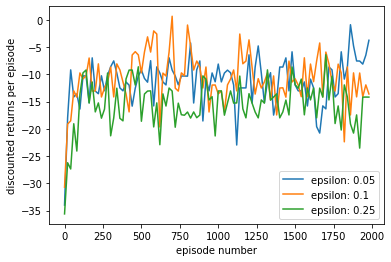

In [16]:
#parameter adjusting for epsilon e for Q2c4
iterations = 10
episode_num = 2000
epsilons = [0.05, 0.1, 0.25]
repeat_reward = np.zeros((len(epsilons),iterations,episode_num))
for idx,e in enumerate(epsilons):
    for i in (range(iterations)):
        agent = MC_agent(epsilon=e)
        agent.play(episode_num)
        repeat_reward[idx][i] = agent.total_reward
mean_reward = np.mean(repeat_reward[0], axis=0)
mean_reward1 = np.mean(repeat_reward[1], axis=0)
mean_reward2 = np.mean(repeat_reward[2], axis=0)
idx, val = smooth_rewards(mean_reward,20)
_, val1 = smooth_rewards(mean_reward1,20)
_, val2 = smooth_rewards(mean_reward2,20)
plt.plot(idx, val, label="epsilon: 0.05")
plt.plot(idx, val1, label="epsilon: 0.1")
plt.plot(idx, val2, label="epsilon: 0.25")
plt.xlabel('episode number')
plt.ylabel('discounted returns per episode')
plt.legend()
plt.show()

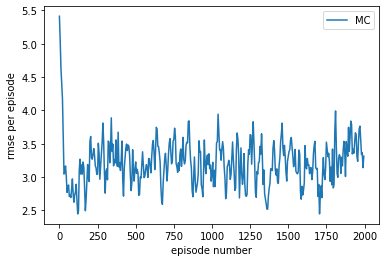

In [42]:
#plot rms per episode for MC
iterations = 10
episode_num = 2000
repeat_data = np.zeros((iterations,episode_num))
for i in (range(iterations)):
    agent = MC_agent()
    agent.play(episode_num)
    repeat_data[i] = agent.total_rms
mean_data = np.mean(repeat_data, axis=0)
idx, val = smooth_rewards(mean_data,5)
plt.plot(idx, val, label="MC")
plt.xlabel('episode number')
plt.ylabel('rmse per episode')
plt.legend()
plt.show()

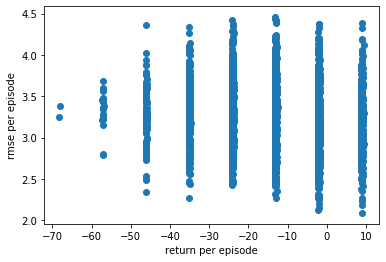

In [53]:
#plot rmse against return per episode for MC after training for Q2e2
iterations = 10
episode_num = 2000
repeat_data = np.zeros((2,iterations,episode_num))
for i in (range(iterations)):
    agent = MC_agent()
    agent.train_q_values(TRAINED_Q)
    agent.play(episode_num)
    repeat_data[0][i] = agent.total_rms
    repeat_data[1][i] = agent.total_reward
mean_rms = np.mean(repeat_data[0], axis=0)
mean_reward = np.mean(repeat_data[1], axis=0)
# _, val = smooth_rewards(mean_rms,5)
# _, val1 = smooth_rewards(mean_reward,5)
plt.scatter(mean_reward, mean_rms)
plt.xlabel('return per episode')
plt.ylabel('rmse per episode')
plt.show()

In [37]:
class TD_agent(object):
    def __init__(self, epsilon=0.1, step_size=0.2):
        self.agent_env = GridWorldenv()
        self.actions = list(range(self.agent_env.action_size)) #[0,1,2,3]
        self.step_size = step_size
        self.epsilon = epsilon
        self.discount = 0.55
        self.trace = []
        self.q_values = np.zeros((self.agent_env.num_state,len(self.actions)))
    
    def argmax(self, q_values):
        #argmax with random tie-breaking
        top=float("-inf")
        ties=[]

        for i in self.actions:
            if q_values[i]>top:
                top=q_values[i]
                ties=[]

            if q_values[i]==top:
                ties.append(i)

        return np.random.choice(ties)
    
    def agent_start(self, state):
        #agent choose an action given the current state, according to epsilon-greedy
        if np.random.uniform(0,1)<self.epsilon:
            #take random action
            action = np.random.choice(self.actions)
        else:
            #take action according to the q function
            action = self.argmax(self.q_values[state])
        self.prev_state = state
        self.prev_action = action
        return int(action)
    
    def agent_step(self, reward, state):
        # Choose action using epsilon greedy.
        if np.random.uniform(0,1)<self.epsilon:
            action = np.random.choice(self.actions)
        else:
            action = self.argmax(self.q_values[state])
        
        #perform q update
        self.q_values[self.prev_state][self.prev_action] += self.step_size*(reward+self.discount*self.q_values[state][action]-self.q_values[self.prev_state][self.prev_action])
        
        self.prev_state = state
        self.prev_action = action
        return int(action)
    
    def reset(self):
        self.trace = []
        self.agent_env = GridWorldenv()
        self.prev_state = None
        self.prev_action = None
    
    def play(self, num_episode=2000):
        self.total_reward = np.zeros(num_episode)
        self.total_rms = np.zeros(num_episode)
        for i in range(num_episode):
            self.agent_env.env_start()
            #cumulative_reward = 0
            action = self.agent_start(self.agent_env.curr_state)
            state, reward, done = self.agent_env.env_step(action)
            self.agent_env.curr_state = state
            self.trace.append((self.agent_env.locs[state], action, reward))
            #counter = 0
            while not done:
                #cumulative_reward += reward
                action = self.agent_step(reward=reward,state=self.agent_env.curr_state)
                state, reward, done = self.agent_env.env_step(action)
                self.agent_env.curr_state = state
                self.trace.append((self.agent_env.locs[state], action, reward))
                #counter += 1
            #episode has terminated, update q table
            self.q_values[self.prev_state][self.prev_action] += self.step_size*(reward+0-self.q_values[self.prev_state][self.prev_action])
            #cumulative_reward += reward
            self.total_rms[i] = self.get_rms()
            self.total_reward[i] = self.back_discounted_reward(self.trace)
            
            #reset the env at the end of an episode
            if i<(num_episode-1):
                self.reset()
    
    def back_discounted_reward(self, sample):
        #find the backward discounted reward for one episode
        G_return = 0
        for tup in sample:
            reward = tup[2]
            G_return = self.discount*G_return + reward
        return G_return
    
    def get_rms(self):
        V_estimate = np.max(self.q_values,axis=1)
        rms = np.sqrt(np.mean((V_estimate-V_OPT)**2))
        return rms
    
    def train_q_values(self, q_values):
        #takes in q_values for training
        self.q_values = q_values


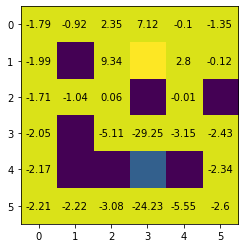

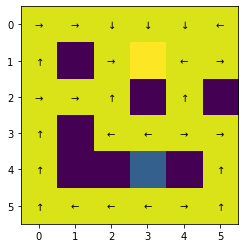

In [47]:
#train the TD agent
agent1 = TD_agent()
agent1.play(num_episode=500000)
TRAINED_Q_TD = agent1.q_values #make the trained data as global variable
grid4 = GridWorldenv()
V_opt_td = np.max(agent1.q_values,axis=1) #the optimal value function
P_opt_td = np.argmax(agent1.q_values,axis=1)
grid4.draw_value(V_opt_td)
grid4.draw_deterministic_policy(P_opt_td)

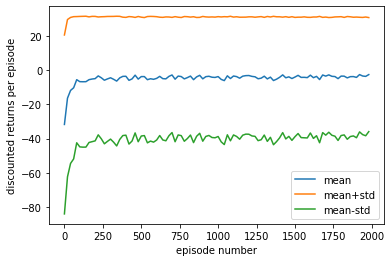

In [8]:
#plot learning curve for Q2d3
iterations = 100
episode_num = 2000
repeat_reward = np.zeros((iterations,episode_num))
for i in (range(iterations)):
    agent = TD_agent()
    agent.play(episode_num)
    repeat_reward[i] = agent.total_reward
mean_reward = np.mean(repeat_reward, axis=0)
std_reward = np.std(repeat_reward, axis=0)
plus = mean_reward + std_reward
minus = mean_reward - std_reward
#no smoothing
idx, val = smooth_rewards(mean_reward,1)
_, val1 = smooth_rewards(plus,1)
_, val2 = smooth_rewards(minus,1)
fig1 = plt.figure()
plt.plot(idx, val, label="mean")
plt.plot(idx, val1, label="mean+std")
plt.plot(idx, val2, label="mean-std")
plt.xlabel('episode number')
plt.ylabel('discounted returns per episode')
plt.title('TD')
plt.legend()
plt.show()

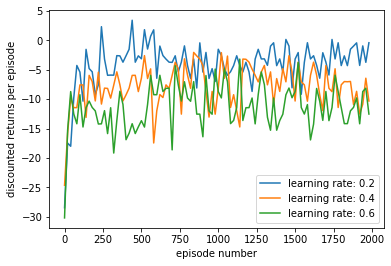

In [13]:
#parameter adjusting for learning rate a for Q2d4
iterations = 10
episode_num = 2000
stepsizes = [0.2, 0.4, 0.6]
repeat_reward = np.zeros((len(stepsizes),iterations,episode_num))
for i in (range(iterations)):
    for idx,a in enumerate(stepsizes):
        agent = TD_agent(step_size=a)
        agent.play(episode_num)
        repeat_reward[idx][i] = agent.total_reward
mean_reward = np.mean(repeat_reward[0], axis=0)
mean_reward1 = np.mean(repeat_reward[1], axis=0)
mean_reward2 = np.mean(repeat_reward[2], axis=0)
idx, val = smooth_rewards(mean_reward,20)
_, val1 = smooth_rewards(mean_reward1,20)
_, val2 = smooth_rewards(mean_reward2,20)
plt.plot(idx, val, label="learning rate: 0.2")
plt.plot(idx, val1, label="learning rate: 0.4")
plt.plot(idx, val2, label="learning rate: 0.6")
plt.xlabel('episode number')
plt.ylabel('discounted returns per episode')
plt.legend()
plt.show()

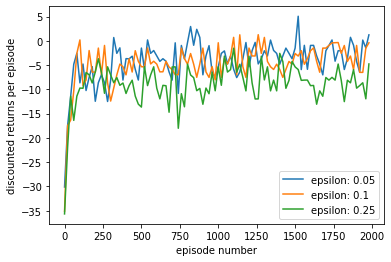

In [15]:
#parameter adjusting for epsilon e for Q2d4
iterations = 10
episode_num = 2000
epsilons = [0.05, 0.1, 0.25]
repeat_reward = np.zeros((len(epsilons),iterations,episode_num))
for idx,e in enumerate(epsilons):
    for i in (range(iterations)):
        agent = TD_agent(epsilon=e)
        agent.play(episode_num)
        repeat_reward[idx][i] = agent.total_reward
mean_reward = np.mean(repeat_reward[0], axis=0)
mean_reward1 = np.mean(repeat_reward[1], axis=0)
mean_reward2 = np.mean(repeat_reward[2], axis=0)
idx, val = smooth_rewards(mean_reward,20)
_, val1 = smooth_rewards(mean_reward1,20)
_, val2 = smooth_rewards(mean_reward2,20)
plt.plot(idx, val, label="epsilon: 0.05")
plt.plot(idx, val1, label="epsilon: 0.1")
plt.plot(idx, val2, label="epsilon: 0.25")
plt.xlabel('episode number')
plt.ylabel('discounted returns per episode')
plt.legend()
plt.show()

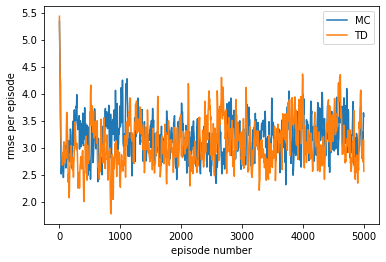

In [44]:
#plot rms per episode for MC,TD, for Q2e1
iterations = 10
episode_num = 5000
repeat_data1 = np.zeros((iterations,episode_num))
repeat_data2 = np.zeros((iterations,episode_num))
for i in (range(iterations)):
    agent1 = MC_agent()
    agent1.play(episode_num)
    repeat_data1[i] = agent1.total_rms
    agent2 = TD_agent()
    agent2.play(episode_num)
    repeat_data2[i] = agent2.total_rms
mean_data1 = np.mean(repeat_data1, axis=0)
idx, val1 = smooth_rewards(mean_data1,5)
mean_data2 = np.mean(repeat_data2, axis=0)
idx, val2 = smooth_rewards(mean_data2,5)
plt.plot(idx, val1, label="MC")
plt.plot(idx, val2, label="TD")
plt.xlabel('episode number')
plt.ylabel('rmse per episode')
plt.legend()
plt.show()

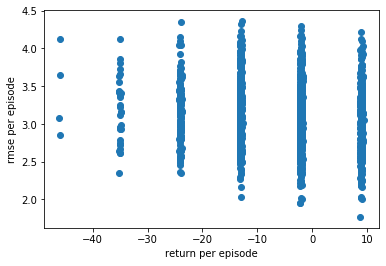

In [52]:
#plot rmse against return per episode for TD after training for Q2e2
iterations = 10
episode_num = 2000
repeat_data = np.zeros((2,iterations,episode_num))
for i in (range(iterations)):
    agent = TD_agent()
    agent.train_q_values(TRAINED_Q_TD)
    agent.play(episode_num)
    repeat_data[0][i] = agent.total_rms
    repeat_data[1][i] = agent.total_reward
mean_rms = np.mean(repeat_data[0], axis=0)
mean_reward = np.mean(repeat_data[1], axis=0)
# _, val = smooth_rewards(mean_rms,5)
# _, val1 = smooth_rewards(mean_reward,5)
plt.scatter(mean_reward, mean_rms)
plt.xlabel('return per episode')
plt.ylabel('rmse per episode')
plt.show()

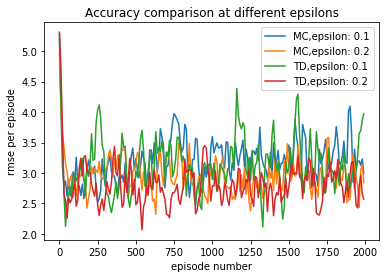

In [57]:
#comparison of MC and TD: learning accuracy(rmse) for Q2e3
#for different learning parameter epsilon e
iterations = 10
episode_num = 2000
epsilons = [0.1, 0.2]
repeat_reward1 = np.zeros((len(epsilons),iterations,episode_num))
repeat_reward2 = np.zeros((len(epsilons),iterations,episode_num))
for i in (range(iterations)):
    for idx,s in enumerate(epsilons):
        agent1 = MC_agent(epsilon=s)
        agent1.play(episode_num)
        repeat_reward1[idx][i] = agent1.total_rms
        agent2 = TD_agent(epsilon=s)
        agent2.play(episode_num)
        repeat_reward2[idx][i] = agent2.total_rms
mean_mc_1 = np.mean(repeat_reward1[0], axis=0)
mean_mc_2 = np.mean(repeat_reward1[1], axis=0)
mean_td_1 = np.mean(repeat_reward2[0], axis=0)
mean_td_2 = np.mean(repeat_reward2[1], axis=0)
idx, val1 = smooth_rewards(mean_mc_1,10)
_, val2 = smooth_rewards(mean_mc_2,10)
_, val3 = smooth_rewards(mean_td_1,10)
_, val4 = smooth_rewards(mean_td_2,10)
plt.plot(idx, val1, label="MC,epsilon: 0.1")
plt.plot(idx, val2, label="MC,epsilon: 0.2")
plt.plot(idx, val3, label="TD,epsilon: 0.1")
plt.plot(idx, val4, label="TD,epsilon: 0.2")
plt.xlabel('episode number')
plt.ylabel('rmse per episode')
plt.title('Accuracy comparison at different epsilons')
plt.legend()
plt.show()

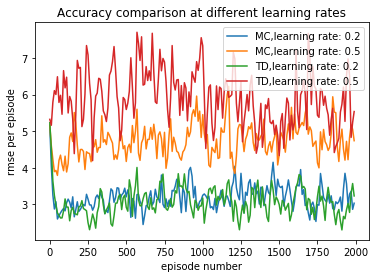

In [56]:
#comparison of MC and TD: learning accuracy(rmse) for Q2e3
#for different learning parameter learning rate a
iterations = 10
episode_num = 2000
stepsizes = [0.2, 0.5]
repeat_reward1 = np.zeros((len(stepsizes),iterations,episode_num))
repeat_reward2 = np.zeros((len(stepsizes),iterations,episode_num))
for i in (range(iterations)):
    for idx,a in enumerate(stepsizes):
        agent1 = MC_agent(step_size=a)
        agent1.play(episode_num)
        repeat_reward1[idx][i] = agent1.total_rms
        agent2 = TD_agent(step_size=a)
        agent2.play(episode_num)
        repeat_reward2[idx][i] = agent2.total_rms
mean_mc_1 = np.mean(repeat_reward1[0], axis=0)
mean_mc_2 = np.mean(repeat_reward1[1], axis=0)
mean_td_1 = np.mean(repeat_reward2[0], axis=0)
mean_td_2 = np.mean(repeat_reward2[1], axis=0)
idx, val1 = smooth_rewards(mean_mc_1,10)
_, val2 = smooth_rewards(mean_mc_2,10)
_, val3 = smooth_rewards(mean_td_1,10)
_, val4 = smooth_rewards(mean_td_2,10)
plt.plot(idx, val1, label="MC,learning rate: 0.2")
plt.plot(idx, val2, label="MC,learning rate: 0.5")
plt.plot(idx, val3, label="TD,learning rate: 0.2")
plt.plot(idx, val4, label="TD,learning rate: 0.5")
plt.xlabel('episode number')
plt.ylabel('rmse per episode')
plt.title('Accuracy comparison at different learning rates')
plt.legend()
plt.show()

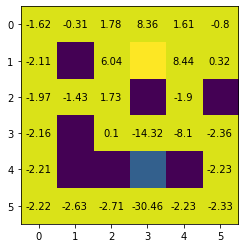

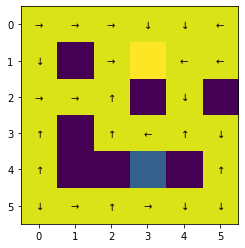

In [24]:
#MC optimal
agent0 = MC_agent()
agent0.play(num_episode=500000)
grid3 = GridWorldenv()
V_opt_mc = np.max(agent0.qvalues,axis=1) #the optimal value function
P_opt_mc = np.argmax(agent0.qvalues,axis=1)
grid3.draw_value(V_opt_mc)
grid3.draw_deterministic_policy(P_opt_mc)

In [33]:
#rms for mc
rms_mc = np.sqrt(np.mean((V_opt_mc-V_OPT)**2))
rms_mc

2.7351947032795874

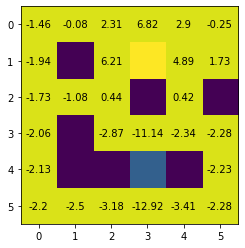

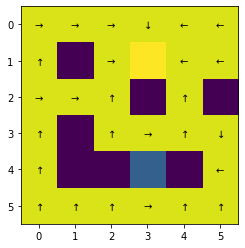

In [25]:
#TD optimal
agent1 = TD_agent()
agent1.play(num_episode=500000)
grid4 = GridWorldenv()
V_opt_td = np.max(agent1.q_values,axis=1) #the optimal value function
P_opt_td = np.argmax(agent1.q_values,axis=1)
grid4.draw_value(V_opt_td)
grid4.draw_deterministic_policy(P_opt_td)

In [34]:
#rms for td
rms_td = np.sqrt(np.mean((V_opt_td-V_OPT)**2))
rms_td

1.8449377748528213